In [2]:
!pip install duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 65.6 MB/s eta 0:00:00:00:0100:01


In [3]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 44.1 MB/s eta 0:00:00:00:0100:01


In [4]:
import duckdb
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from scipy.stats import chi2_contingency

In [5]:
train_path = '/scratch/namana.s/train.parquet'

con = duckdb.connect()

one_binds = con.query(f"""(SELECT count(*)
                FROM parquet_scan('{train_path}')
                WHERE binds = 1)
""").fetchone()[0]

df_train = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT {one_binds}*2)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1)""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [7]:
df_train.head()

,id,buildingblock1_smiles,buildingblock2_smiles,buildingblock3_smiles,molecule_smiles,protein_name,binds
0,280062242,O=C(O)[C@@H]1CCCN1C(=O)OCC1c2ccccc2-c2ccccc21,CC1(C)CC(CCN)C(=O)N1.Cl,Nc1nc(Br)cn2ccnc12,CC1(C)CC(CCNc2nc(Nc3nc(Br)cn4ccnc34)nc(N3CCC[C...,sEH,0
1,233778334,O=C(O)C1CCN(C(=O)OCC2c3ccccc3-c3ccccc32)C1,Cl.NCCn1cnnn1,Cc1ccsc1CN,Cc1ccsc1CNc1nc(NCCn2cnnn2)nc(N2CCC(C(=O)N[Dy])...,HSA,0
2,89163436,O=C(N[C@@H](CC1CC1)C(=O)O)OCC1c2ccccc2-c2ccccc21,Nc1ccc(N2CCCC2=O)cc1,Cc1cccc(OCCCN)c1C.Cl,Cc1cccc(OCCCNc2nc(Nc3ccc(N4CCCC4=O)cc3)nc(N[C@...,HSA,0
3,217212621,O=C(Nc1cccnc1C(=O)O)OCC1c2ccccc2-c2ccccc21,Cc1cccc(OCCCN)c1C.Cl,NCc1cnn(Cc2ccccc2)c1,Cc1cccc(OCCCNc2nc(NCc3cnn(Cc4ccccc4)c3)nc(Nc3c...,BRD4,0
4,220687283,O=C(Nc1cncc(C(=O)O)n1)OCC1c2ccccc2-c2ccccc21,Cl.NCCNC(=O)c1ccc(Cl)cc1,Nc1ccc2c(c1)COC2=O,O=C(NCCNc1nc(Nc2ccc3c(c2)COC3=O)nc(Nc2cncc(C(=...,sEH,0


In [8]:
df_train.count()

id                       4769718
buildingblock1_smiles    4769718
buildingblock2_smiles    4769718
buildingblock3_smiles    4769718
molecule_smiles          4769718
protein_name             4769718
binds                    4769718
dtype: int64

In [9]:
def calculate_molecular_weight(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Descriptors.MolWt(mol)
        else:
            return None
    except:
        return None

# Add molecular weight column
df_train['molecular_weight'] = df_train['molecule_smiles'].apply(calculate_molecular_weight)

In [10]:
df_train['molecular_weight']

0          719.937
1          591.006
2          720.179
3          740.173
4          722.454
            ...   
4769713    717.171
4769714    591.954
4769715    618.976
4769716    658.057
4769717    669.970
Name: molecular_weight, Length: 4769718, dtype: float64

In [11]:
# Define weight bins
bins = [0, 200, 400, 600, 800, 1000, float('inf')]  # Example bins
labels = ['<200', '200-400', '400-600', '600-800', '800-1000', '>1000']

# Bin the molecular weights
df_train['weight_bin'] = pd.cut(df_train['molecular_weight'], bins=bins, labels=labels)
print(df_train[['molecular_weight', 'weight_bin', 'binds']])

         molecular_weight weight_bin  binds
0                 719.937    600-800      0
1                 591.006    400-600      0
2                 720.179    600-800      0
3                 740.173    600-800      0
4                 722.454    600-800      0
...                   ...        ...    ...
4769713           717.171    600-800      1
4769714           591.954    400-600      1
4769715           618.976    600-800      1
4769716           658.057    600-800      1
4769717           669.970    600-800      1

[4769718 rows x 3 columns]


In [12]:
from scipy.stats import chi2_contingency

results = {}

for protein, group in df_train.groupby('protein_name'):
    # Create contingency table
    contingency_table = pd.crosstab(group['weight_bin'], group['binds'])
    
    # Perform chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Store results
    results[protein] = {
        'chi2_stat': chi2_stat,
        'p_value': p_value,
        'dof': dof,
        'expected': expected,
        'observed': contingency_table.values
    }
    print(f"\nProtein: {protein}")
    print(f"Contingency Table for Observed Frequencies:\n{contingency_table}")
    print(f"Chi-Square Statistic: {chi2_stat}")
    print(f"P-value: {p_value}")
    print(f"Degrees of Freedom: {dof}")
    print("Expected Frequencies Table:")
    print(expected)


Protein: BRD4
Contingency Table for Observed Frequencies:
binds            0       1
weight_bin                
400-600      11975    2675
600-800     841904  366637
800-1000    203900   87386
>1000         4534     266
Chi-Square Statistic: 2386.4722660639045
P-value: 0.0
Degrees of Freedom: 3
Expected Frequencies Table:
[[ 10243.61288297   4406.38711703]
 [845039.32813634 363501.67186366]
 [203673.78991323  87612.21008677]
 [  3356.26906746   1443.73093254]]

Protein: HSA
Contingency Table for Observed Frequencies:
binds            0       1
weight_bin                
400-600      11552    6339
600-800     840624  344741
800-1000    204497   56388
>1000         4392     942
Chi-Square Statistic: 6739.215983785697
P-value: 0.0
Degrees of Freedom: 3
Expected Frequencies Table:
[[ 12918.5688188    4972.4311812 ]
 [855917.46285238 329447.53714762]
 [188377.44264108  72507.55735892]
 [  3851.52568775   1482.47431225]]

Protein: sEH
Contingency Table for Observed Frequencies:
binds       

/tmp/ipykernel_33/809194671.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_train.groupby(['protein_name', 'weight_bin'])['binds']
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.g

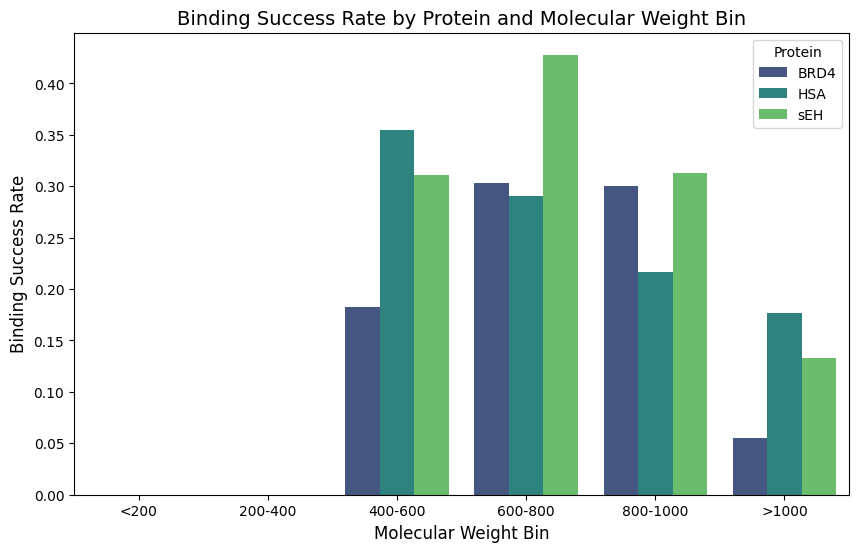

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

binding_success = (
    df_train.groupby(['protein_name', 'weight_bin'])['binds']
    .mean()
    .reset_index()
    .rename(columns={'binds': 'binding_success_rate'})
)

# Visualize the Binding Success Rate
plt.figure(figsize=(10, 6))
sns.barplot(
    data=binding_success,
    x='weight_bin',
    y='binding_success_rate',
    hue='protein_name',
    palette='viridis'
)
plt.title('Binding Success Rate by Protein and Molecular Weight Bin', fontsize=14)
plt.xlabel('Molecular Weight Bin', fontsize=12)
plt.ylabel('Binding Success Rate', fontsize=12)
plt.legend(title='Protein', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()